In [1]:
from google.cloud import storage
import os
import json
import subprocess 
from pathlib import Path
from glob import glob 
import time

bucket_name = "mina_mainnet_blocks"
output_dir = "."
def download_blocks():
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    command = f"gsutil -m cp -r gs://{bucket_name} {output_dir}"
    print(f"Running command: {command}")
    sync_blocks = subprocess.run(command.split(), stdout=subprocess.PIPE, text=True)

    return glob(output_dir + "/" + bucket_name + "/*")


start = time.time()
files = download_blocks()
end = time.time()
print(f"{len(files)} Blocks Downloaded in {end-start} seconds")

Running command: gsutil -m cp -r gs://mina_mainnet_blocks .
8118 Blocks Downloaded in 55.87828588485718 seconds


In [2]:
def load_blocks(block_file_list):
    blocks = {}
    for file in block_file_list:
        state_hash = file.split("-")[1].split(".")[0]
        with open(file, "r", encoding = "ISO-8859-1") as json_file:
            contents = json_file.read()
            #contents = unicode(contents, errors='replace')
            block = json.loads(contents)
            blocks[state_hash] = block
    return blocks

start = time.time()
blocks = load_blocks(files)
end = time.time()
print(f"Parsed {len(blocks.keys())} Blocks in {end-start} seconds")

Parsed 7828 Blocks in 50.663711071014404 seconds


In [24]:
blocks.keys()

dict_keys(['3NLvPghhj9QxtEM9o9oMKumgokGh6Lv7qdoARcaCDiX7PJn6zgxy', '3NKbvChF886jw9k3NtrNNLrKenaQB5gCm9DCfWhXwq284hMAVg1t', '3NLuvEuNZjUGAD9N94ZA1A85HHtf1vGF5Y1jNxgjVPhT5tMUWFTi', '3NKJ53fL5ANyX5BnWGJBwg22Zwiv7vvaMVwLhMCMfZ1Fnit2VmnB', '3NKQt7XP7tQNGkBASATmzSuohvUeGeoitEK3ptwUv6d62F6yc2Sy', '3NKb1nA7iuHzGBG2hu7pT9P1JKwNU3wsoCSVrQ7K9kC56RBJrXTe', '3NKSwUY5z26UcasD3iFCkRHMMrrvWMfY46kUeZW7XH2kGT6VTqG6', '3NK7XMw3qcqPvo2XnWF86j5EQkAAioQGw2wDB8sx5YXNqxr2UDjC', '3NKKTFjpmAdczJV2Rv3vMsYWDLGvzmKrCyT3k52dkZytrUPgbyzX', '3NKQMATK8ophUKZ1imjmbzmn6UAs86yy7dK6fivi84swfkyokqCi', '3NLZsCyRG24rznibzs92nugszt9EeZGfcF1GbuRRC7MJefz9GutC', '3NLsamoGAFg2xapbs5gNhTArb2zH4SmrZR3YGoLf16swU1RiB3UA', '3NL66uHLjcxpVwopNFinbqHbYRgoejS7q9fAvbvfjGCSwnbP3UsQ', '3NKaedAQ1R1Az8RZdVWRu4Gt3utnZygt5HT7rdEfWSdxqafuq8ey', '3NL4v5C4KsGp5oTDi2TkE5pf3n7fv6WnQqs1naD8ErANUgu2euUX', '3NKuCzuGoGTsBUZKZPEbLGidnat92DnkRf8goC4ZstwGSSxhYARE', '3NKpZPFFqSErtVx6uhU8TCzxMWrj5qT62HSL3TPd6d5dX5KRdWHH', '3NKeP3o4j7f81toULvwr8Wq1dPwJ8Hcuu8py

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import logging
import sys
import time

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()

network_graph = nx.DiGraph()

for state_hash in list(blocks.keys()): 
    block = blocks[state_hash]
    previous_state_hash = block["protocol_state"]["previous_state_hash"]
    # Add a node for this block
    if state_hash not in network_graph: 
        network_graph.add_node(state_hash)
    if previous_state_hash not in network_graph:
        network_graph.add_node(previous_state_hash)
    
    network_graph.add_edge(state_hash, previous_state_hash, weight=1)

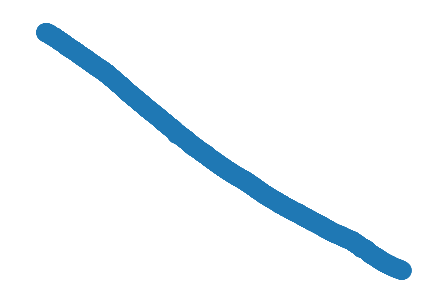

In [22]:
nx.draw_kamada_kawai(network_graph)

In [11]:
from graph_tool import Graph
from graph_tool.draw import graph_draw, graphviz_draw, arf_layout, fruchterman_reingold_layout, sfdp_layout
g = Graph()
vertices = {}
for state_hash in list(blocks.keys()): 
    block = blocks[state_hash]
    previous_state_hash = block["protocol_state"]["previous_state_hash"]
    # Add a node for this block
    if state_hash not in vertices:
        vertices[state_hash] = g.add_vertex()
    if previous_state_hash not in vertices: 
        vertices[previous_state_hash] = g.add_vertex()
    g.add_edge(vertices[state_hash], vertices[previous_state_hash])

#graphviz_draw(g, vertex_text=g.vertex_index, layout="neato", output="chain.pdf")       

In [17]:
pos = sfdp_layout(g, K=1)


In [26]:
#graphviz_draw(g, pos=pos, splines=True, output="chain.pdf", 
graph_draw(g, pos=pos, output_size=(1800,600), output="chain.pdf", )

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x2f08d0a60, at 0x2f075a5e0>

In [27]:
g.save("chain.dot", fmt="dot")